# Music Generation using GANS

## 0. Setting up libraries, importing the dataset

In [ ]:
# !wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/maestro-v3.0.0-midi.zip -d /content/drive/MyDrive/

In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 28.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592341 sha256=375b43c625428f9a54e35b923c37a8b022513abd105f224c2a4026bae6753fbf
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
!pip install music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
path = '/content/drive/MyDrive/maestro-v3.0.0/'

In [ ]:
import pretty_midi
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm
# import music21

## 1. Visualizing and handling the data

### 1.1 Read some sample file names from the maestro metadata

In [ ]:
metadata = pd.read_csv(path + "maestro-v3.0.0.csv")

subset = metadata[metadata['split'] == 'train'].sample(n=50,random_state=42)
midi_files = subset['midi_filename'].tolist()
midi_files

['2004/MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_02_Track02_wav.midi',
 '2009/MIDI-Unprocessed_13_R1_2009_01-03_ORIG_MID--AUDIO_13_R1_2009_13_R1_2009_03_WAV.midi',
 '2004/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_01_Track01_wav.midi',
 '2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--2.midi',
 '2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_17_R2_2014_wav.midi',
 '2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--2.midi',
 '2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--1.midi',
 '2017/MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--3.midi',
 '2014/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--3.midi',
 '2006/MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_03_Track03_wav.midi',
 '2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--2.midi',
 '2008/MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--3.midi',
 '2015/MIDI-Unprocess

### 1.2 Play with a single midi file

In [ ]:
def load_midi(file_path):
  try:
    midi = pretty_midi.PrettyMIDI(file_path)
    return midi
  except Exception as e:
    print(f"Error Loading {file_path}: {e}")
    return None

In [ ]:
file_path = os.path.join(path,midi_files[0])
midi = load_midi(file_path)

In [ ]:
# save_path = os.path.join(save_path_midifiles, "sample_maestro_midi.mid")
# midi.write(save_path)

In [ ]:
def explore_midi(midi):

  print(f"Duration: {midi.get_end_time():.2f} seconds")
  print(f"Instruments: {len(midi.instruments)}")

  notes = [note for instr in midi.instruments for note in instr.notes]
  pitches = [note.pitch for note in notes]
  velocities = [note.velocity for note in notes]
  durations = [note.end - note.start for note in notes]

  print(f"Total Notes: {len(notes)}")
  print(f"Pitch Range: {min(pitches)}-{max(pitches)}")
  print(f"Velocity Range: {min(velocities)} - {max(velocities)}")
  print(f"Duration Range: {min(durations)} - {max(durations)}")

In [ ]:
explore_midi(midi)

Duration: 682.38 seconds
Instruments: 1
Total Notes: 5153
Pitch Range: 29-97
Velocity Range: 6 - 107
Duration Range: 0.0010416666666515084 - 3.890625


In [ ]:
def plot_pitch_histogram(notes):
  pitches = [note.pitch for note in notes]
  plt.hist(pitches,bins=range(128),edgecolor='black')
  plt.xlabel('MIDI Pitch')
  plt.ylabel('Frequency')
  plt.title('Note Pitch Detection')
  plt.show()

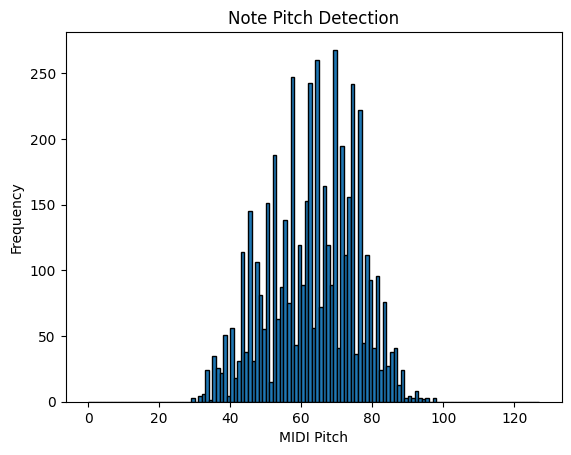

In [ ]:
notes = midi.instruments[0].notes
plot_pitch_histogram(notes)

In [ ]:
def plot_piano_roll(midi,start_time=0,end_time=10):
  piano_roll = midi.get_piano_roll(fs=10)
  plt.imshow(piano_roll[:,int(start_time * 10): int(end_time * 10)],
             aspect='auto',origin='lower',cmap='viridis')
  plt.xlabel('Time (0.1s steps)')
  plt.ylabel('MIDI Pitch')
  plt.colorbar(label='Velocity')
  plt.title('Piano Roll Snippet')
  plt.show()

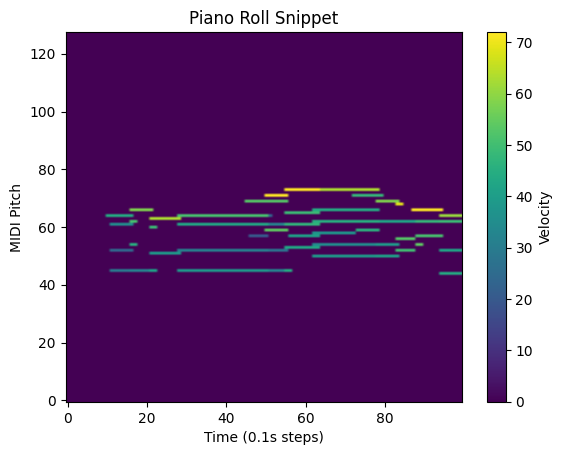

In [ ]:
plot_piano_roll(midi)

## Preprocess the sample files

In [ ]:
def convert_midi_to_piano_roll(midi,fs=30):
  # Returns a piano roll with shape (time_steps, 131) where:
    # - 0-127: Note velocities (0-1 normalized)
    # - 128: Sustain pedal (0-1)
    # - 129: Sostenuto pedal (0-1)
    # - 130: Una Corda pedal (0-1)

  piano_roll = midi.get_piano_roll(fs=fs) # (128, time_steps)
  piano_roll /= 127.0

  time_steps = piano_roll.shape[1]
  pedals = np.zeros((3,time_steps))

  clamp_count = 0
  for instrument in midi.instruments:
    for control in instrument.control_changes:
      if control.number == 64:
        idx = min(int(control.time * fs),time_steps-1)
        pedals[0,idx] = control.value / 127.0
      elif control.number == 66:
        idx = min(int(control.time * fs),time_steps-1)
        pedals[1,idx] = control.value / 127.0
      elif control.number == 67:
        idx = min(int(control.time * fs),time_steps-1)
        pedals[2,idx] = control.value / 127.0

  #     if int(control.time * fs) >= time_steps:
  #       clamp_count += 1
  # print(f"Clamped {clamp_count} pedal events out of {len(midi.instruments[0].control_changes)}")
  full_roll = np.vstack([piano_roll,pedals]).T
  return full_roll

In [ ]:
sample_roll = convert_midi_to_piano_roll(midi)
sample_roll.shape

(68237, 131)

In [ ]:
def slice_by_measure(midi_file_path, measures_per_slice=4, fs=30):
    from music21 import converter

    score = converter.parse(midi_file_path)
    measures = list(score.recurse().getElementsByClass('Measure'))

    midi = load_midi(midi_file_path)
    if midi is None:
        return []

    piano_roll = convert_midi_to_piano_roll(midi, fs=fs)
    sequences = []

    for i in range(0, len(measures), measures_per_slice):
        start_measure = measures[i]
        end_measure = measures[min(i + measures_per_slice - 1, len(measures) - 1)]

        start_time = start_measure.offset
        end_time = end_measure.offset + end_measure.duration.quarterLength

        start_idx = int(start_time * fs)
        end_idx = int(end_time * fs)

        if end_idx <= piano_roll.shape[0]:
            segment = piano_roll[start_idx:end_idx]
            if segment.shape[0] > 0:
                sequences.append(segment)

    return sequences


In [ ]:
def process(midi_files, root_dir, fs=30, measures_per_slice=4):
    all_sequences = []
    for filename in tqdm(midi_files, desc='Processing MIDI Files'):
        file_path = os.path.join(root_dir, filename)
        try:
            sequences = slice_by_measure(file_path, measures_per_slice=measures_per_slice, fs=fs)
            all_sequences.extend(sequences)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Pad/truncate sequences to consistent length if needed for batching
    max_len = max(seq.shape[0] for seq in all_sequences)
    target_len = min(max_len, fs * measures_per_slice * 4)  # e.g., 4 measures ≈ 8 seconds @ fs=50

    # Make all sequences the same length (for batching later)
    processed = []
    for seq in all_sequences:
        if seq.shape[0] >= target_len:
            processed.append(seq[:target_len])
        else:
            pad_width = target_len - seq.shape[0]
            padded = np.pad(seq, ((0, pad_width), (0, 0)))
            processed.append(padded)

    return np.stack(processed)


In [ ]:
train_files = metadata[metadata['split'] == 'train'].sample(n=200,random_state=42)['midi_filename'].tolist()
len(train_files)

In [ ]:
sequences = process(train_files,path)
print(f"{sequences.shape}\n Total Sequences: {sequences.shape[0]}, Shape per Sequence: {sequences.shape[1:]}")

Processing Midi Files:   0%|          | 0/962 [00:00<?, ?it/s]

(286567, 200, 131)
 Total Sequences: 286567, Shape per Sequence: (200, 131)


In [ ]:
print(type(sequences))  # Should be numpy.ndarray
print(sequences.dtype)  # Should be a numeric type (e.g., float32, float64)
print(sequences.shape)  # Verify the shape

<class 'numpy.ndarray'>
float64
(286567, 200, 131)


In [ ]:
# print(type(tensor_data))  # Should be torch.Tensor
# print(tensor_data.dtype)  # Should be torch.float32
# print(tensor_data.shape)  # Verify the shape

In [ ]:
# !pip install h5py

In [ ]:
import pandas as pd
import numpy as np

# Convert your NumPy array to a Pandas DataFrame
df = pd.DataFrame(sequences.reshape(sequences.shape[0], -1))  # Flatten if needed
N = 60000
df_sample = df.sample(n=N, random_state=42)

# Save as Parquet
df_sample.to_parquet(path + 'train_200', compression='gzip')

In [ ]:
# tensor_data = torch.from_numpy(sequences).float()
# save_path = path + 'train_maestro_piano_rolls.pt'
# torch.save(tensor_data,save_path,pickle_protocol=4)

## Note

**For ease of use, the train data - and, in the future,validation and test data - has already been saved as tensors. Therefore, we can simply load them and start from building the dataloaders step instead of from the beginning**

In [ ]:
!fallocate -l 4G /swapfile
!chmod 600 /swapfile
!mkswap /swapfile
!swapon /swapfile
!free -h

mkswap: /swapfile: warning: wiping old swap signature.
Setting up swapspace version 1, size = 4 GiB (4294963200 bytes)
no label, UUID=35bdd039-f1b2-4ebe-9f2e-496287b3d602
swapon: /swapfile: swapon failed: Invalid argument
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.5Gi       9.6Gi       1.0Mi       1.6Gi        10Gi
Swap:             0B          0B          0B


##Create Dataloaders

In [ ]:
df = pd.read_parquet(path + 'train_200.parquet')
data = df.to_numpy().reshape(-1, 131, 480)  # Reshape back if needed

data.shape

(3209, 131, 480)

In [ ]:
# sample_data = df_sample.to_numpy().reshape(-1, 131, 200)  # Reshape back if needed
# sample_data.shape

(60000, 131, 200)

In [ ]:
from torch.utils.data import DataLoader

tensor_data = torch.from_numpy(data).float()
tensor_data.shape

torch.Size([3209, 131, 480])

In [ ]:
batch_size = 64
train_dataloader = DataLoader(tensor_data,batch_size=batch_size,shuffle=True)
batch = next(iter(train_dataloader))
batch.shape

torch.Size([64, 131, 480])

In [ ]:
batch[5:]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2677, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1260,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2520, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.6378, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.4016, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

## 4. Create Generator and Discriminator

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
  def __init__(self, latent_dim,seq_len,num_features):
    super().__init__()

    self.seq_len = seq_len
    self.num_features = num_features

    self.linear_block = nn.Sequential(
        nn.Linear(latent_dim,256 * seq_len // 4),
        nn.ReLU(),
        nn.Unflatten(1,(256,seq_len // 4))
    )
    self.conv_block = nn.Sequential(
        nn.ConvTranspose1d(256,128,kernel_size=4,stride=2,padding=2),
        nn.ReLU(),
        nn.ConvTranspose1d(128,64,kernel_size=4,stride=2,padding=2),
        nn.ReLU(),
        nn.ConvTranspose1d(64,num_features,kernel_size=4,stride=1,padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    x = self.linear_block(x)
    x = self.conv_block(x)
    return x

In [ ]:
from torch.nn.utils.spectral_norm import spectral_norm

class Discriminator(nn.Module):
  def __init__(self, num_features,seq_len):
    super().__init__()
    self.conv_block = nn.Sequential(
        spectral_norm(nn.Conv1d(num_features, 32, kernel_size=4, stride=2, padding=2)),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        spectral_norm(nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
    )

    # reduced_seq_len = seq_len // (2**3)  # Since 3 Conv layers reduce length by 2^3 = 8
    self.fc = nn.Sequential(
          nn.Flatten(),
          spectral_norm(nn.Linear(128, 1)),  # Dynamically adjust for different seq_len
          nn.Sigmoid()
    )

  def forward(self,x):
    x = self.conv_block(x)
    # print(x.shape)
    x = torch.mean(x,dim=2)
    # print(x.shape)
    return self.fc(x)

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [ ]:
latent_dim = 256
generator = Generator(latent_dim=latent_dim,seq_len=480,num_features=131).to(device).float()
discriminator = Discriminator(num_features=131,seq_len=480).to(device).float()

In [ ]:
test_input = torch.randn(batch_size,131,480)
test_input.shape

torch.Size([64, 131, 200])

In [ ]:
output = discriminator(test_input.to(device))
output.shape

torch.Size([64, 1])

## 5. Train the models

In [ ]:
from torch.optim import Adam

optimizer_G = Adam(generator.parameters(),lr=0.0001,betas=(0.5, 0.999))
optimizer_D = Adam(discriminator.parameters(),lr=0.0002,betas=(0.5, 0.999))

loss_fn = nn.BCELoss()

In [ ]:
import torch.nn as nn
import torch
from tqdm import tqdm

def train_step(generator: nn.Module,
               discriminator: nn.Module,
               optimizer_D: torch.optim.Optimizer,
               optimizer_G: torch.optim.Optimizer,
               loss_fn: nn.Module,
               device: torch.device,
               dataloader: torch.utils.data.DataLoader,
               latent_dim: int):

    generator.train()
    discriminator.train()

    d_running_loss = 0.0
    g_running_loss = 0.0

    progress_bar = tqdm(dataloader, total=len(dataloader), desc='Training', leave=True)

    for batch in progress_bar:
        real_data = batch.to(device).float()

        batch_size = real_data.size(0)

        # -------------------
        # 1️⃣ Train Discriminator
        # -------------------
        optimizer_D.zero_grad()

        # Use soft labels
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        fake_labels = torch.full((batch_size, 1), 0.1, device=device)

        # Real
        d_real_pred = discriminator(real_data)
        d_real_loss = loss_fn(d_real_pred, real_labels)

        # Fake
        z = torch.randn((batch_size, latent_dim), device=device)
        fake_data = generator(z)
        d_fake_pred = discriminator(fake_data.detach())
        d_fake_loss = loss_fn(d_fake_pred, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -------------------
        # 2️⃣ Train Generator (Twice per batch)
        # -------------------
        for _ in range(1):
            optimizer_G.zero_grad()
            z = torch.randn((batch_size, latent_dim), device=device)
            fake_data = generator(z)
            g_pred = discriminator(fake_data)
            g_loss = loss_fn(g_pred, real_labels)  # Trick the discriminator
            g_loss.backward()
            optimizer_G.step()

        # Log average losses
        d_running_loss += d_loss.item()
        g_running_loss += g_loss.item()

    avg_d_loss = d_running_loss / len(dataloader)
    avg_g_loss = g_running_loss / (len(dataloader) * 2)  # generator trained twice per batch

    return avg_d_loss, avg_g_loss


In [ ]:
d_losses,g_losses = [],[]

In [ ]:

num_epochs = 50

for epoch in range(num_epochs):
  print(f"Epoch: {epoch+1}\n-------------------")
  d_loss,g_loss = train_step(generator,
             discriminator,
             optimizer_D,
             optimizer_G,
             loss_fn,
             device,
             train_dataloader,
             latent_dim)

  d_losses.append(d_loss)
  g_losses.append(g_loss)
  print(f"Epoch {epoch+1}/{num_epochs} - D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

Epoch: 1
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.43it/s]


Epoch 1/50 - D Loss: 1.0156 | G Loss: 0.8471
Epoch: 2
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.46it/s]


Epoch 2/50 - D Loss: 1.1386 | G Loss: 0.4503
Epoch: 3
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s]


Epoch 3/50 - D Loss: 1.1677 | G Loss: 0.3702
Epoch: 4
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 4/50 - D Loss: 1.2202 | G Loss: 0.4515
Epoch: 5
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 5/50 - D Loss: 1.2386 | G Loss: 0.4331
Epoch: 6
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 6/50 - D Loss: 1.2152 | G Loss: 0.4404
Epoch: 7
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 7/50 - D Loss: 1.2094 | G Loss: 0.4423
Epoch: 8
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 8/50 - D Loss: 1.2086 | G Loss: 0.4526
Epoch: 9
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 9/50 - D Loss: 1.1865 | G Loss: 0.4149
Epoch: 10
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.40it/s]


Epoch 10/50 - D Loss: 1.2846 | G Loss: 0.4351
Epoch: 11
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.47it/s]


Epoch 11/50 - D Loss: 1.3002 | G Loss: 0.4098
Epoch: 12
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 12/50 - D Loss: 1.2439 | G Loss: 0.4678
Epoch: 13
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.48it/s]


Epoch 13/50 - D Loss: 1.3051 | G Loss: 0.4199
Epoch: 14
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.45it/s]


Epoch 14/50 - D Loss: 1.2827 | G Loss: 0.4204
Epoch: 15
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.47it/s]


Epoch 15/50 - D Loss: 1.2800 | G Loss: 0.4214
Epoch: 16
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 16/50 - D Loss: 1.1245 | G Loss: 0.4518
Epoch: 17
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s]


Epoch 17/50 - D Loss: 1.1651 | G Loss: 0.5660
Epoch: 18
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 18/50 - D Loss: 1.3109 | G Loss: 0.3793
Epoch: 19
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 19/50 - D Loss: 1.3624 | G Loss: 0.4280
Epoch: 20
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 20/50 - D Loss: 1.2745 | G Loss: 0.3793
Epoch: 21
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 21/50 - D Loss: 1.3249 | G Loss: 0.4011
Epoch: 22
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 22/50 - D Loss: 1.2759 | G Loss: 0.4306
Epoch: 23
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 23/50 - D Loss: 1.2977 | G Loss: 0.4595
Epoch: 24
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 24/50 - D Loss: 1.3156 | G Loss: 0.3880
Epoch: 25
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 25/50 - D Loss: 1.2861 | G Loss: 0.4005
Epoch: 26
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 26/50 - D Loss: 1.2707 | G Loss: 0.4428
Epoch: 27
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 27/50 - D Loss: 1.2407 | G Loss: 0.4525
Epoch: 28
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 28/50 - D Loss: 1.3306 | G Loss: 0.4226
Epoch: 29
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 29/50 - D Loss: 1.3037 | G Loss: 0.3952
Epoch: 30
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.53it/s]


Epoch 30/50 - D Loss: 1.2437 | G Loss: 0.4516
Epoch: 31
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 31/50 - D Loss: 1.2964 | G Loss: 0.4539
Epoch: 32
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 32/50 - D Loss: 1.3326 | G Loss: 0.3852
Epoch: 33
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.49it/s]


Epoch 33/50 - D Loss: 1.2747 | G Loss: 0.3847
Epoch: 34
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 34/50 - D Loss: 1.2453 | G Loss: 0.4620
Epoch: 35
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 35/50 - D Loss: 1.3871 | G Loss: 0.3950
Epoch: 36
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 36/50 - D Loss: 1.2924 | G Loss: 0.3845
Epoch: 37
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 37/50 - D Loss: 1.2598 | G Loss: 0.4487
Epoch: 38
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 38/50 - D Loss: 1.3156 | G Loss: 0.3860
Epoch: 39
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 39/50 - D Loss: 1.2662 | G Loss: 0.3961
Epoch: 40
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 40/50 - D Loss: 1.2974 | G Loss: 0.4266
Epoch: 41
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Epoch 41/50 - D Loss: 1.3010 | G Loss: 0.4002
Epoch: 42
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 42/50 - D Loss: 1.2957 | G Loss: 0.4074
Epoch: 43
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 43/50 - D Loss: 1.2914 | G Loss: 0.4169
Epoch: 44
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 44/50 - D Loss: 1.2034 | G Loss: 0.4561
Epoch: 45
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 45/50 - D Loss: 1.3088 | G Loss: 0.4096
Epoch: 46
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 46/50 - D Loss: 1.2572 | G Loss: 0.4206
Epoch: 47
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]


Epoch 47/50 - D Loss: 1.2462 | G Loss: 0.4973
Epoch: 48
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 48/50 - D Loss: 1.3854 | G Loss: 0.4055
Epoch: 49
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


Epoch 49/50 - D Loss: 1.3388 | G Loss: 0.3539
Epoch: 50
-------------------


Training: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]

Epoch 50/50 - D Loss: 1.2935 | G Loss: 0.4134


### IMPROVEMENTS

* Added `Dropout` Layers

* Added `Spectral Norm`

* Changed `Learning Rate` (discriminator = 0.0001, generator = 0.0003)

* Changed `labels` (Real = 0.9, Fake = 0.1)

* Trained Generator Twice per Epoch

* Reverted `Learning Rate for Generator`

* Changed `Learning Rate` (discriminator = 0.00005)

* Added Betas (0.5,0.999) to both optimizers

* Train Generator once per Epoch

* Lr = 0.0001 G, 0.0002 D

* Increased Disc LR to 0.0004

* Changed Beta to (0.5,0.9) for Disc

* Reverted changed lr and beta

## 6. Check Outputs/ Save Model

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_diagram(d_losses,g_losses):
  plt.plot(d_losses, label="Discriminator Loss")
  plt.plot(g_losses, label="Generator Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

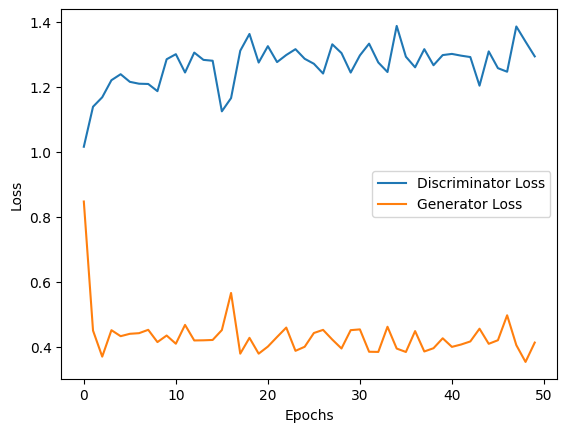

In [ ]:
plot_loss_diagram(d_losses,g_losses)

In [ ]:
save_path_checkpoints = path + 'ModelCheckpoints/'
save_path_midifiles = path + 'MidiFiles/'

In [ ]:
torch.save(generator.state_dict(),save_path_checkpoints + "generator_train_sameoptim.pth")
torch.save(discriminator.state_dict(),save_path_checkpoints + "discriminator_train_sameoptim.pth")

## 7. Check Generated Midi File

In [ ]:
generator.load_state_dict(torch.load(save_path_checkpoints + "generator_train_sameoptim.pth",map_location=torch.device('cpu')))
# generator.to(device)
generator.eval()  # Set to evaluation mode

Generator(
  (linear_block): Sequential(
    (0): Linear(in_features=256, out_features=12800, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 50))
  )
  (conv_block): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(2,))
    (1): ReLU()
    (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(2,))
    (3): ReLU()
    (4): ConvTranspose1d(64, 131, kernel_size=(4,), stride=(1,), padding=(1,))
    (5): Sigmoid()
  )
)

In [ ]:
discriminator.load_state_dict(torch.load(save_path_checkpoints + "discriminator_train_sameoptim.pth"))
discriminator.eval()  # Set to evaluation mode

Discriminator(
  (conv_block): Sequential(
    (0): Conv1d(131, 32, kernel_size=(4,), stride=(2,), padding=(2,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [ ]:
latent_dim = 256           # Your generator's latent dim
num_features = 131         # Typically 128 notes + 3 pedals
total_time = 60            # Seconds of music to generate
fs = 30

In [ ]:
@torch.inference_mode()
def generate_music(generator, latent_dim, num_features, total_time, fs=30,
                   device=device, context_len=16, overlap=8):
    """
    Improved version with:
    - Time-based generation (total_time in seconds)
    - Context preservation with overlap
    - Better latent space conditioning
    """
    generator.eval()

    seq_len = 200  # Match your training sequence length
    total_steps = int(total_time * fs)
    num_segments = int(np.ceil(total_steps / (seq_len - overlap)))

    # Initialize hidden state
    hidden = None
    generated = []
    prev_context = None

    for _ in range(num_segments):
        # 1. Generate latent vector with context conditioning
        z = torch.randn(1, latent_dim, device=device)

        # Condition on previous context
        if prev_context is not None:
            context_flat = prev_context.flatten()[:latent_dim//2]
            z[:, :len(context_flat)] = 0.7*z[:, :len(context_flat)] + 0.3*context_flat

        # 2. Generate sequence
        segment = generator(z).squeeze(0)  # [seq_len, num_features]

        # 3. Maintain overlap
        if generated:
            # Blend overlapping regions
            overlap_weights = torch.linspace(0, 1, overlap, device=device).unsqueeze(1)  # [8, 1]
            generated[-1][-overlap:] = (1 - overlap_weights) * generated[-1][-overlap:] + overlap_weights * segment[:overlap]

            # overlap_weights = torch.linspace(0, 1, overlap)
            # generated[-1][-overlap:] = (1 - overlap_weights)*generated[-1][-overlap:] + overlap_weights*segment[:overlap]
            generated.append(segment[overlap:])
        else:
            generated.append(segment)

        # 4. Update context (use LSTM if available)
        prev_context = segment[-context_len:]

    # Trim to exact duration
    piano_roll = torch.cat(generated)[:total_steps]
    return piano_roll.cpu().numpy()

In [ ]:
def piano_roll_to_midi(piano_roll, fs=30, note_threshold=0.1, pedal_threshold=0.5, program=0):
    """
    Enhanced MIDI conversion with:
    - Sustain-pedal aware note duration extension
    - Proper pedal CC event handling
    - Velocity-sensitive note conversion
    - Overlap-safe note management

    Args:
        piano_roll: (time_steps, 131) numpy array
        fs: Sampling frequency (steps/second)
        note_threshold: Minimum activation value for notes (0-1)
        pedal_threshold: Pedal activation threshold (0-1)
        program: MIDI program number

    Returns:
        pretty_midi.PrettyMIDI object
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)
    time_step = 1.0 / fs

    # Pre-process pedals with hysteresis to avoid fluttering
    sustain = _clean_pedal_signal(piano_roll[:, 128], pedal_threshold)
    sostenuto = _clean_pedal_signal(piano_roll[:, 129], pedal_threshold)
    una_corda = _clean_pedal_signal(piano_roll[:, 130], pedal_threshold)

    # Process pedals first to establish timeline
    pedals = {
        64: _find_pedal_changes(sustain, fs),
        66: _find_pedal_changes(sostenuto, fs),
        67: _find_pedal_changes(una_corda, fs)
    }

    # Add pedal events to instrument
    for cc_number, events in pedals.items():
        for time, value in events:
            instrument.control_changes.append(
                pretty_midi.ControlChange(
                    number=cc_number,
                    value=127 if value else 0,
                    time=time
                )
            )

    # Track sustain state for note duration extension
    sustain_timeline = _create_timeline(sustain, fs)

    # Process notes with sustain-aware duration
    for pitch in range(128):
        velocity_signal = piano_roll[:, pitch]
        activations = velocity_signal > note_threshold
        starts, ends = _find_contiguous_regions(activations)

        for start_idx, end_idx in zip(starts, ends):
            # Calculate base duration
            start_time = start_idx * time_step
            original_end = end_idx * time_step

            # Find sustain extension window
            sustain_extension = _find_sustain_extension(
                end_idx,
                sustain_timeline,
                max_extension=4.0  # Max 4 second sustain
            )

            # Calculate final end time
            end_time = max(original_end, sustain_extension)

            # Calculate velocity as peak activation
            velocity = int(127 * np.max(velocity_signal[start_idx:end_idx]))

            instrument.notes.append(
                pretty_midi.Note(
                    velocity=velocity,
                    pitch=pitch,
                    start=start_time,
                    end=end_time
                )
            )

    midi.instruments.append(instrument)
    return midi

# Helper functions --------------------------------------------------

def _clean_pedal_signal(signal, threshold, hysteresis=0.1):
    """Add hysteresis to pedal detection to avoid rapid fluttering"""
    cleaned = np.zeros_like(signal, dtype=bool)
    state = False
    for i in range(len(signal)):
        if state:
            if signal[i] < threshold - hysteresis:
                state = False
        else:
            if signal[i] > threshold + hysteresis:
                state = True
        cleaned[i] = state
    return cleaned

def _find_pedal_changes(cleaned_signal, fs=30):
    """Convert cleaned pedal signal to (time, value) events"""
    changes = np.where(np.diff(cleaned_signal.astype(int)))[0] + 1
    events = []
    for idx in changes:
        events.append((idx/fs, cleaned_signal[idx]))
    return events

def _create_timeline(signal, fs=30):
    """Create sustain active intervals (start, end) times"""
    starts = np.where(np.diff(signal.astype(int)) == 1)[0] / fs
    ends = np.where(np.diff(signal.astype(int)) == -1)[0] / fs
    if signal[0]:
        starts = np.insert(starts, 0, 0.0)
    if signal[-1]:
        ends = np.append(ends, len(signal)/fs)
    return list(zip(starts, ends))

def _find_sustain_extension(end_idx, timeline, max_extension):
    """Find how long sustain pedal keeps note ringing"""
    end_time = end_idx / fs
    for sustain_start, sustain_end in timeline:
        if sustain_start <= end_time <= sustain_end:
            return min(sustain_end, end_time + max_extension)
    return end_time

def _find_contiguous_regions(activations):
    """Improved version with min note duration check"""
    diff = np.diff(activations.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    if activations[0]:
        starts = np.insert(starts, 0, 0)
    if activations[-1]:
        ends = np.append(ends, len(activations))

    # Filter out very short notes (<50ms)
    valid = (ends - starts) >= (0.05 * fs)
    return starts[valid], ends[valid]

In [ ]:
# def piano_roll_to_midi(piano_roll, fs=100, note_threshold=0.5, pedal_threshold=0.5):
#     """
#     Convert piano roll (shape: [seq_len, 131]) back to MIDI.

#     Args:
#         piano_roll (np.ndarray): Shape (seq_len, 131) in [0, 1].
#         fs (int): Frames per second (must match preprocessing `fs`).
#         note_threshold (float): Note activation threshold (0-1).
#         pedal_threshold (float): Pedal activation threshold (0-1).

#     Returns:
#         pretty_midi.PrettyMIDI: Reconstructed MIDI object.
#     """
#     midi = pretty_midi.PrettyMIDI()
#     instrument = pretty_midi.Instrument(program=0)  # Piano

#     # --------------------------------------------------
#     # 1. Convert Notes (Channels 0-127)
#     # --------------------------------------------------
#     for pitch in range(128):
#         # Find contiguous note activations
#         activations = piano_roll[:, pitch] > note_threshold
#         starts, ends = _find_contiguous_regions(activations)

#         # Add notes
#         for start_idx, end_idx in zip(starts, ends):
#             start_time = start_idx / fs
#             end_time = end_idx / fs
#             velocity = int(np.mean(piano_roll[start_idx:end_idx, pitch])) * 127
#             instrument.notes.append(
#                 pretty_midi.Note(
#                     velocity=velocity,
#                     pitch=pitch,
#                     start=start_time,
#                     end=end_time
#                 )
#             )

#     # --------------------------------------------------
#     # 2. Convert Pedals (Channels 128-130)
#     # --------------------------------------------------
#     # Sustain Pedal (CC64)
#     sustain = piano_roll[:, 128] > pedal_threshold
#     for t in np.where(sustain)[0]:
#         instrument.control_changes.append(
#             pretty_midi.ControlChange(
#                 number=64,
#                 value=127,
#                 time=t / fs
#             )
#         )

#     # Sostenuto Pedal (CC66)
#     sostenuto = piano_roll[:, 129] > pedal_threshold
#     for t in np.where(sostenuto)[0]:
#         instrument.control_changes.append(
#             pretty_midi.ControlChange(
#                 number=66,
#                 value=127,
#                 time=t / fs
#             )
#         )

#     # Una Corda Pedal (CC67)
#     una_corda = piano_roll[:, 130] > pedal_threshold
#     for t in np.where(una_corda)[0]:
#         instrument.control_changes.append(
#             pretty_midi.ControlChange(
#                 number=67,
#                 value=127,
#                 time=t / fs
#             )
#         )

#     midi.instruments.append(instrument)
#     return midi


In [ ]:
# def _find_contiguous_regions(activations):
#     """Find start/end indices of contiguous activated regions."""
#     diff = np.diff(activations.astype(int))
#     starts = np.where(diff == 1)[0] + 1
#     ends = np.where(diff == -1)[0] + 1

#     # Handle edge cases
#     if activations[0]:
#         starts = np.insert(starts, 0, 0)
#     if activations[-1]:
#         ends = np.append(ends, len(activations))

#     return starts, ends

In [ ]:
# # Generate a batch
# z = torch.randn(1, latent_dim)  # Replace with your latent dim
# generated_batch = generator(z)  # Shape: (32, 131, 200)

# # Transpose to (32, 200, 131)
# generated_batch = generated_batch.permute(0, 2, 1)
# generated_batch.shape

In [ ]:
# import matplotlib.pyplot as plt

# def plot_piano_roll(piano_roll):
#     plt.figure(figsize=(10, 5))
#     plt.imshow(piano_roll.T, aspect='auto', cmap='gray_r', origin='lower')
#     plt.xlabel("Time Steps")
#     plt.ylabel("MIDI Pitch")
#     plt.title("Generated Piano Roll")
#     plt.colorbar(label="Activation")
#     plt.show()

# z = torch.randn(1, latent_dim)  # Replace with your latent dim
# generated_sample = generator(z)  # Shape: (32, 131, 200)
# generated_sample.shape

torch.Size([1, 131, 195])

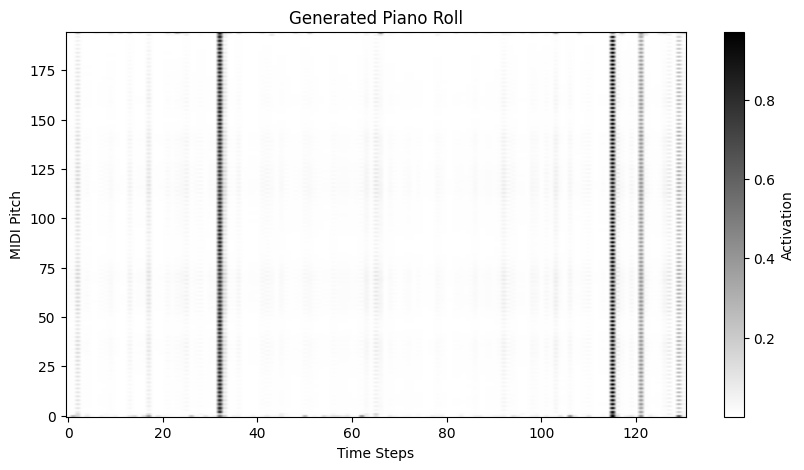

In [ ]:

# plot_piano_roll(generated_sample[0].detach().cpu().numpy())  # Convert tensor to numpy

In [ ]:
# # Convert the first sample to MIDI
# sample_sequence = generated_batch[0].detach().cpu().numpy()
# sample_sequence.shape

(195, 131)

In [ ]:
# midi = piano_roll_to_midi(sample_sequence, fs=100)

In [ ]:
piano_roll = generate_music(
    generator=generator,
    latent_dim=latent_dim,
    num_features=num_features,
    total_time=total_time,
    fs=30,
    device=device
)

In [ ]:
print("Piano roll range:", piano_roll.min(), piano_roll.max())

Piano roll range: 1.49972e-06 0.9839617


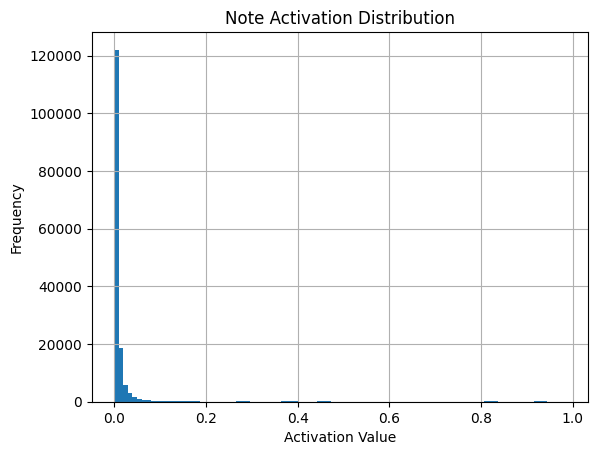

In [ ]:
import matplotlib.pyplot as plt

plt.hist(piano_roll[:, :128].flatten(), bins=100)
plt.title("Note Activation Distribution")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_piano_roll(piano_roll):
    plt.figure(figsize=(10, 5))
    plt.imshow(piano_roll.T, aspect='auto', cmap='gray_r', origin='lower')
    plt.xlabel("Time Steps")
    plt.ylabel("MIDI Pitch")
    plt.title("Generated Piano Roll")
    plt.colorbar(label="Activation")
    plt.show()

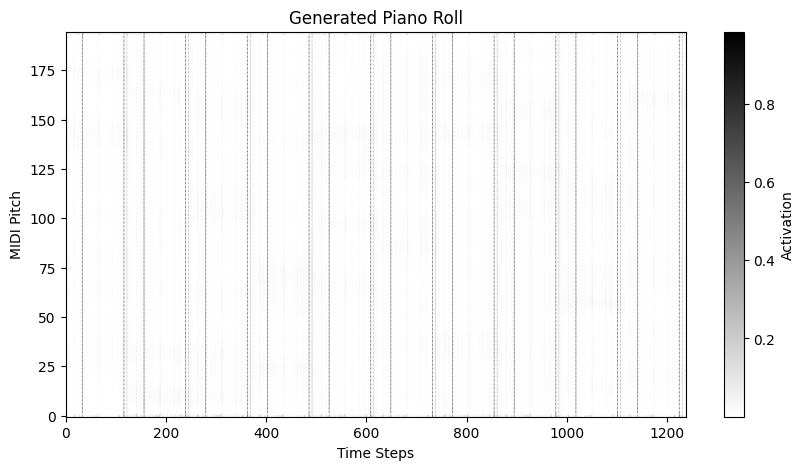

In [ ]:
plot_piano_roll(piano_roll)  # Convert tensor to numpy

In [ ]:
midi = piano_roll_to_midi(piano_roll, fs=30)

In [ ]:
save_path = os.path.join(save_path_midifiles, "sample_checkpoint2.mid")
midi.write(save_path)

In [ ]:
midi_generated = pretty_midi.PrettyMIDI(save_path)

In [ ]:
explore_midi(midi)

Duration: 40.80 seconds
Instruments: 1
Total Notes: 384
Pitch Range: 0-126
Velocity Range: 14 - 124
Duration Range: 0.06666666666666288 - 0.06666666666666998


In [ ]:
import torch
import torch.nn as nn

class GeneratorLSTM(nn.Module):
    def __init__(self, latent_dim, seq_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features

        # Fully connected layers to transform latent vector
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, seq_len * 128),  # Project to match LSTM input
            nn.Tanh()
        )

        # LSTM to capture time dependencies
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True)

        # Convolutional layers to refine output (no permute needed)
        self.conv_block = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.ConvTranspose1d(64, num_features, kernel_size=4, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        batch_size = z.size(0)

        # Pass through linear layers
        x = self.linear(z)  # Shape: (batch, seq_len * 128)
        x = x.view(batch_size, self.seq_len, 128)  # Reshape to LSTM format

        # LSTM forward pass
        x, _ = self.lstm(x)  # Output: (batch, seq_len, 128)

        # Reshape directly for Conv1D (batch, 128, seq_len)
        x = x.transpose(1, 2)  # Swap seq_len and features to match Conv1D format

        # Pass through convolutional layers
        x = self.conv_block(x)  # Output: (batch, num_features, seq_len)

        return x


In [ ]:
latent_dim = 256
generatorlstm = GeneratorLSTM(latent_dim=latent_dim,seq_len=1000,num_features=131).to(device).float()
discriminator = Discriminator(num_features=131,seq_len=1000).to(device).float()

In [ ]:
from torch.optim import Adam

optimizer_G = Adam(generatorlstm.parameters(),lr=0.0002)
optimizer_D = Adam(discriminator.parameters(),lr=0.00005)

loss_fn = nn.BCELoss()

In [ ]:
d_losses,g_losses = [],[]
num_epochs = 3

for epoch in range(num_epochs):
  print(f"Epoch: {epoch+1}\n-------------------")
  d_loss,g_loss = train_step(generatorlstm,
             discriminator,
             optimizer_D,
             optimizer_G,
             loss_fn,
             device,
             train_dataloader,
             latent_dim)

  d_losses.append(d_loss)
  g_losses.append(g_loss)
  print(f"Epoch {epoch+1}/{num_epochs} - D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")